# CarND - Behavorial Cloning - Project3


#### File structure

- CarND-BehavorialCloning/ ---- Root folder
    - data/ ----------------------- Training image data.
        - IMG/ ------------------ Center, left and right images (Not included).
        - driving_log.csv ------- Log for name of the images with steering angle, throttle, break and speed.
    - drive.py -------------------- Connects to Udacity simulator and predicts with the model, images from simulator.
    - model.py ------------------ The deep neural network model. Based on Nvidia's blog. *
    - data_processing.py ------ Data augmentation and feed the model with training data.
    - model.json ---------------- Json representation of the model
    - model.h5 ------------------ Saved weights from the model training. 
    - BehavorialCloning.ipyn -- Jupyter Notebook. Documentation for this project.(This notebook)
    

*https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/



In [36]:
# Imports
import os, csv, json, math, cv2
import numpy as np
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Functions

# Generate batch to train with augmentation
def generateTrainingBatch(data, batch_size):
    while 1:    
        batch_x = np.zeros((batch_size, 66, 200, 3)) # 160, 320
        batch_y = np.zeros(batch_size)
        i = 0
        while i < batch_size:
            # Get random index in data
            rint = np.random.randint(len(data)-1)
            # Get random type of image. center, left or right image
            rtype = np.random.randint(3)
            # Set offset to steerin angle if left or right image are selected
            offset = 0.0
            if rtype == 1: # Left
                offset = 0.1
            elif rtype == 2: # Right
                offset = -0.1
            # Check if steering is approx straight driving
            if -0.1 < float(data[rint][3]) < 0.1:
                # Throw away some driving straight images. Only get approx 10% of them
                if np.random.randint(10) == 1:
                    batch_x[i] = getImageToBatch(data[rint][rtype])
                    batch_y[i] = float(data[rint][3]) + offset
                    # Randomly approx 1 of 4 flips axes and steering angle
                    if np.random.randint(4) == 1:
                        batch_x[i], batch_y[i] = flip(batch_x[i], batch_y[i])
                    i += 1
            else:
                # Other than approx straight images goes straight into batch with 1 of 4 flipping
                batch_x[i] = getImageToBatch(data[rint][rtype])
                batch_y[i] = float(data[rint][3]) + offset
                if np.random.randint(4) == 1:
                    batch_x[i], batch_y[i] = flip(batch_x[i], batch_y[i])
                i += 1

        # Some extra augmentation
        datagen = ImageDataGenerator(
            #rotation_range=5,
            #width_shift_range=0.1,
            #height_shift_range=0.1
            )

        yield datagen.flow(batch_x, batch_y, batch_size=batch_size)

        
# Flip images by axis and steering angle
def flip(image, angle):
    flippedImg = cv2.flip(image,1)
    flippedAngle = angle * (-1)
    return flippedImg, flippedAngle


# Normalize images
def normalize(image):
    return image / 255.0 - 0.5


# Load image in size (66,200,3) and into array
def getImageToBatch(imgpath):
    return img_to_array(load_img(os.getcwd() + '/data/' + imgpath, target_size=(66,200,3))) 


# Yields batch from generated batch
def getBatch(data, batch_size):
    b = generateTrainingBatch(data, batch_size)
    while 1:
        batch = next(b)
        for x, y in batch:
            yield x, y


# Reads the driving log csv file 
def prepareDataFromCSV(path):
    data = []
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append([row['center'], row['left'], row['right'], row['steering']])
    return data


In [34]:
# The model

def getCNN():
    
    model = Sequential()

    # Noramlization
    model.add(Lambda(normalize, input_shape=(66, 200, 3)))

    # Layer 1 - Convolutional
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 2 - Convolutional
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 3 - Convolutional
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 4 - Convolutional
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
    model.add(Activation('relu'))

    # Layer 4 - Convolutional
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
    model.add(Activation('relu'))

    # Layer 5 Flatten
    model.add(Flatten())

    # Layer 6 - Fully-connected
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Layer 7 - Fully-connected
    model.add(Dense(50))
    model.add(Activation('relu'))

    # Layer 8 - Fully-connected
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    # Layer 9 - Fully-connected
    model.add(Dense(1))
    
    return model


In [ ]:
def main():
    path = '/data/driving_log.csv'
    training_data = prepareDataFromCSV(os.getcwd() + path)
    batch_size = 128
    samples_per_epoch = batch_size * 320
    nb_epoch = 10
    print(" Training data from csv: {}".format(path))
    print(" Batch size: {} \n Number of epochs: {} \n Samples per epoch {}"
        .format(batch_size, nb_epoch, samples_per_epoch))

    # Get model
    model = getCNN()
    # Compile the model with adam optimizer
    adam = Adam(lr = 0.001)
    model.compile(optimizer=adam, loss="mse")
    # Start fit the model
    history = model.fit_generator(
        getBatch(training_data, batch_size), 
        samples_per_epoch=samples_per_epoch,
        nb_epoch=nb_epoch)
    

    # Save model.
    json_string = model.to_json()
    with open('model.json', 'w') as outfile:
        json.dump(json_string, outfile)
    # Save weights.
    model.save_weights('model.h5')

    print("Training finished... Model and weights saved!")


## The model
Built on: 
https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

<img src="files/data/cnn-architecture.png">

Some text here about the model...


## The training

Some text about training the model. Parameters and stuff


## The data

Some text about the data and data augmentation

Steering angle: 0.0 


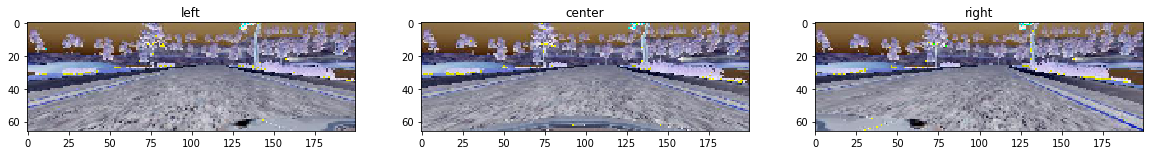

In [44]:
# Example of Center, Left and Right images.
path = '/data/driving_log.csv'
training_data = prepareDataFromCSV(os.getcwd() + path)
imgIndex = 1000 #2351
center = getImageToBatch(training_data[imgIndex][0])
left = getImageToBatch(training_data[imgIndex][1])
right = getImageToBatch(training_data[imgIndex][2])
steering_angle = float(training_data[imgIndex][3])
print('Steering angle: {} '.format(steering_angle))

all_angles_in_set = []
for i in range(len(training_data)):
    all_angles_in_set.append(float(training_data[i][3]))

plt.figure(figsize=(20,20));
plt.subplot(1,3,1, title='left')
plt.imshow(left)
plt.subplot(1,3,2, title='center')
plt.imshow(center)
plt.subplot(1,3,3, title='right')
plt.imshow(right)
    
plt.show()

Steering angles in dataset: 8036


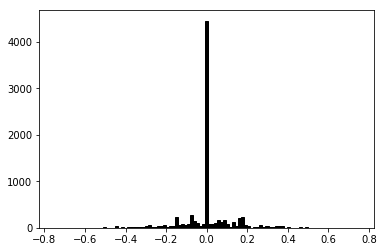

In [49]:
print("Steering angles in dataset: {}".format(len(all_angles_in_set)))
plt.hist(all_angles_in_set, range=(-.75, 0.75), bins=101, fc='k', ec='k')
plt.show()